In [1]:
!pip install medmnist

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 527.2 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 29.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 33.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 36.0 MB/s eta 0:00:00
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114249 sha256

In [2]:
import medmnist
import numpy as np
import torch
import os
import matplotlib.pyplot as plt
from PIL import Image
from scipy.ndimage import gaussian_filter
from medmnist.dataset import OrganAMNIST
from torchvision import transforms
from numpy.random import RandomState
from torchvision.utils import save_image
from medmnist import INFO
from torchvision.transforms import ToTensor
import torch.utils.data as data
from torchvision.transforms.functional import pil_to_tensor

In [3]:
# Image I/O + Preprocessing

def pil_to_tensor(img):
    return transforms.ToTensor()(img)

def tensor_to_np(img_tensor):
    return img_tensor.squeeze(0).numpy()

In [20]:
# Distortion Classes

class AdjustContrast:
    def __init__(self, contrast_level):
        self.contrast_level = contrast_level
    def __call__(self, img):
        arr = np.array(img).astype(np.float32) / 255.0
        arr = np.clip((1 - self.contrast_level) / 2 + self.contrast_level * arr, 0, 1)
        return torch.tensor(arr).unsqueeze(0)

class GaussianNoise:
    def __init__(self, std=0.1):
        self.std = std
    def __call__(self, img):
        tensor = transforms.ToTensor()(img)
        noise = torch.randn_like(tensor) * self.std
        return torch.clamp(tensor + noise, 0, 1)

class SaltPepperNoise:
    def __init__(self, p=0.1):
        self.p = p
    def __call__(self, img):
        tensor = transforms.ToTensor()(img)
        rand = torch.rand_like(tensor)
        tensor[rand < self.p / 2] = 0.0
        tensor[rand > 1 - self.p / 2] = 1.0
        return tensor

class UniformNoise:
    def __init__(self, width=0.2, seed=42):
        self.width = width
        self.rng = RandomState(seed)
    def __call__(self, img):
        arr = np.array(img).astype(np.float32) / 255.0
        noise = self.rng.uniform(-self.width, self.width, size=arr.shape)
        arr = np.clip(arr + noise, 0, 1)
        return torch.tensor(arr).unsqueeze(0)

class GaussianBlur:
    def __init__(self, kernel_size=3, sigma=(0.1, 2.0)):
        # Kernel_size must be an odd positive integer
        assert kernel_size % 2 == 1 and kernel_size > 0
        self.kernel_size = kernel_size
        self.sigma = sigma

    def __call__(self, img):
        # Compose Gaussian blur and tensor conversion
        transform = transforms.Compose([
            transforms.GaussianBlur(kernel_size=self.kernel_size, sigma=self.sigma),
            transforms.ToTensor()
        ])
        return transform(img)

class ColorJitter:
    def __init__(self, brightness=0.4, contrast=0.4):
        self.transform = transforms.Compose([
            transforms.ColorJitter(brightness=brightness, contrast=contrast),
            transforms.ToTensor()
        ])
    def __call__(self, img):
        return self.transform(img)


class AdjustBrightness:
    def __init__(self, brightness_factor):
        # Brightness factor must be >= 0
        assert brightness_factor >= 0.0
        self.brightness_factor = brightness_factor

    def __call__(self, img):
        img_tensor = ToTensor()(img)
        brightened = img_tensor * self.brightness_factor
        return torch.clamp(brightened, 0, 1)

class Rotate90:
    def __call__(self, img):
        arr = np.array(img)
        rotated = np.rot90(arr, k=1)
        return torch.tensor(rotated.astype(np.float32) / 255.0).unsqueeze(0)

class Rotate180:
    def __call__(self, img):
        arr = np.array(img)
        rotated = np.rot90(arr, k=2)
        return torch.tensor(rotated.astype(np.float32) / 255.0).unsqueeze(0)

class Rotate270:
    def __call__(self, img):
        arr = np.array(img)
        rotated = np.rot90(arr, k=3)
        return torch.tensor(rotated.astype(np.float32) / 255.0).unsqueeze(0)

In [5]:
# Visualization

def show_distortion_comparison(dataset, transforms_dict, indices=[]):
    """
    Show the original image and its distortions side by side.

    Parameters:
    - dataset: OrganMNIST dataset (PIL images, transform=None)
    - transforms_dict: dict of {name: transform}
    - indices: list of dataset indices to save
    """
    num_imgs = len(indices)
    num_transforms = len(transforms_dict)

    plt.figure(figsize=(4 * (num_transforms + 1), 3 * num_imgs))

    for row, idx in enumerate(indices):
        raw_img, label = dataset[idx]
        raw_np = tensor_to_np(pil_to_tensor(raw_img))

        # Column 0: Original
        plt.subplot(num_imgs, num_transforms + 1, row * (num_transforms + 1) + 1)
        plt.imshow(raw_np, cmap='gray')
        plt.title(f"Original\nImage: {idx}\nLabel: {label}")
        plt.axis('off')

        # Distorted columns
        for col, (name, transform) in enumerate(transforms_dict.items(), start=1):
            distorted = transform(raw_img)
            distorted_np = tensor_to_np(distorted)
            plt.subplot(num_imgs, num_transforms + 1, row * (num_transforms + 1) + col + 1)
            plt.imshow(distorted_np, cmap='gray')
            plt.title(f"{name}")
            plt.axis('off')

    plt.tight_layout()
    plt.show()

In [6]:
def save_distorted_subset_to_npz(dataset, transforms_dict, indices, output_root, filename="subset_all_in_one.npz"):
    """
    Save a subset of images (original + distortions) into one .npz file.

    Parameters:
    - dataset: OrganMNIST dataset (PIL images, transform=None)
    - split_name: "train", "val", or "test"
    - transforms_dict: dict of {name: transform}
    - indices: list of dataset indices to save
    - output_root: folder to save the single .npz file
    """
    os.makedirs(output_root, exist_ok=True)
    save_path = os.path.join(output_root, filename)

    original_list = []
    label_list = []
    distortion_lists = {name.replace(" ", "_").replace("°", "deg"): [] for name in transforms_dict}

    for idx in indices:
        raw_img, label = dataset[idx]
        orig_np = pil_to_tensor(raw_img).squeeze(0).numpy()
        original_list.append(orig_np)
        label_list.append(label)

        for name, transform in transforms_dict.items():
            key = name.replace(" ", "_").replace("°", "deg")
            transformed_np = transform(raw_img).squeeze(0).numpy()
            distortion_lists[key].append(transformed_np)

    # Build final save dict
    save_dict = {
        "original": np.stack(original_list),
        "label": np.array(label_list)
    }
    for key, value_list in distortion_lists.items():
        save_dict[key] = np.stack(value_list)

    np.savez_compressed(save_path, **save_dict)
    print(f"\n✅ Saved {len(indices)} distorted images to single file: {save_path}")

In [8]:
# Load PIL image version (no transform)
train_raw = OrganAMNIST(split='train', transform=None, download=True, size = 224)
# val_raw = OrganAMNIST(split='val', transform=None, download=True, size = 224)
# test_raw = OrganAMNIST(split='test', transform=None, download=True, size = 224)

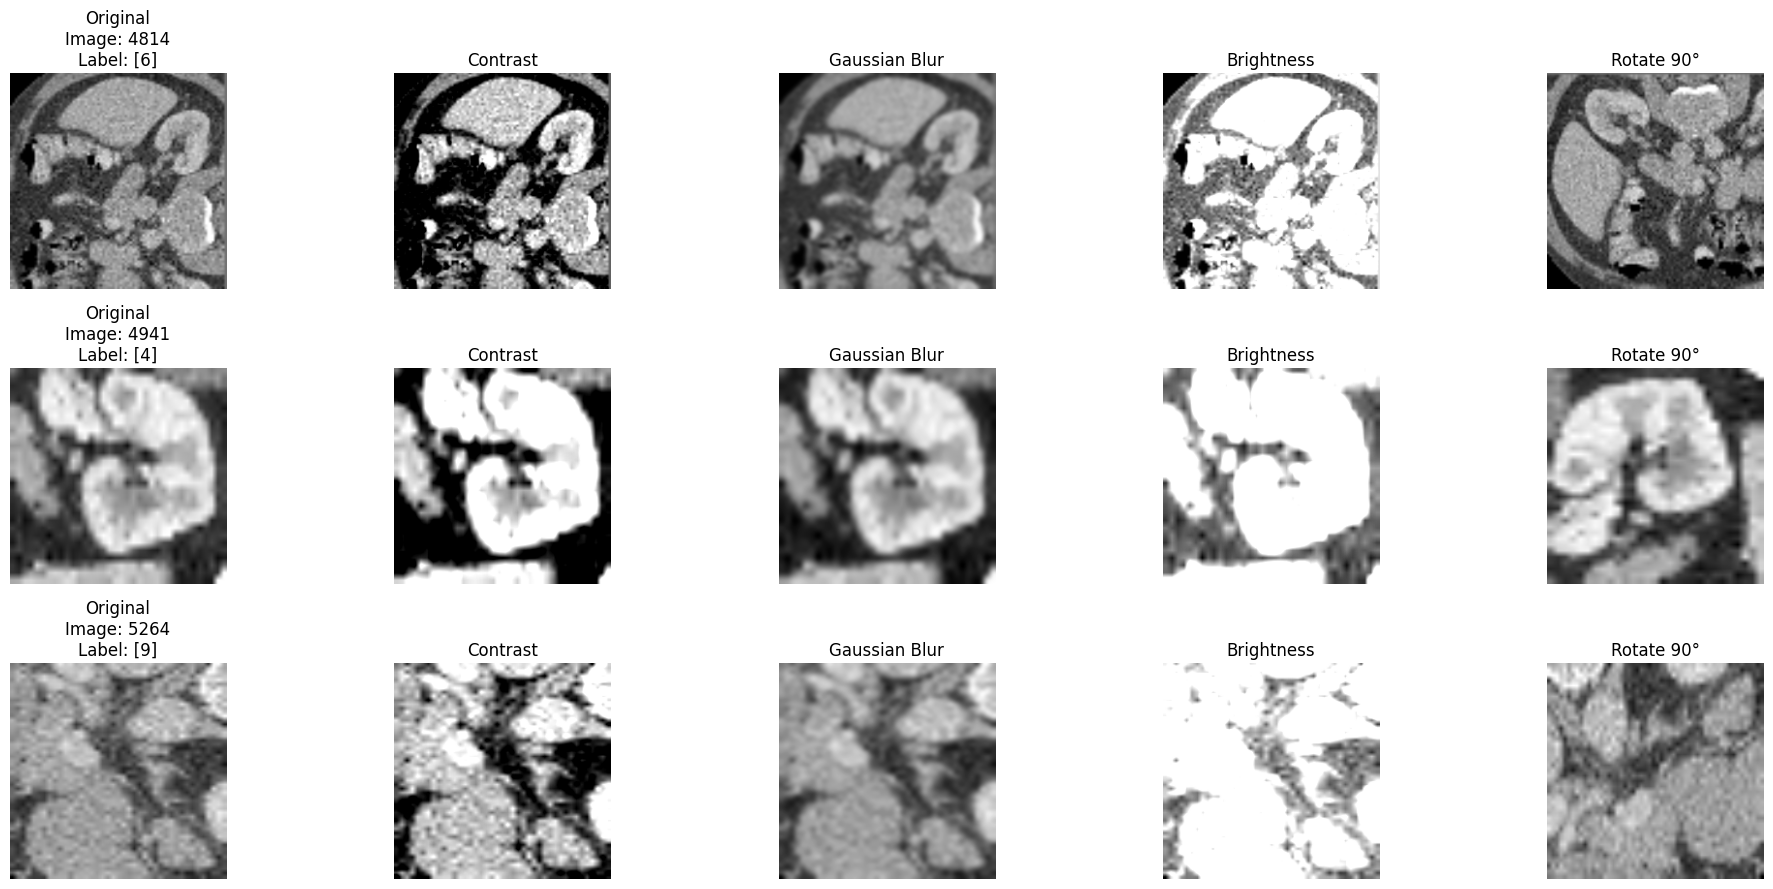

In [10]:
distortions_example = {
        "Contrast": AdjustContrast(contrast_level=2),
        "Gaussian Noise": GaussianNoise(std=0.5),
        "Uniform Noise": UniformNoise(width=0.35),
        "Salt & Pepper": SaltPepperNoise(p=0.2),
        "Gaussian Blur": GaussianBlur(kernel_size=11, sigma=2.0),
        "Brightness": AdjustBrightness(2),
        "Rotate 90°": Rotate90(),
        "Rotate 180°": Rotate180(),
        "Rotate 270°": Rotate270()
    }

distortions = {
        "Contrast": AdjustContrast(contrast_level=2),
        "Gaussian Blur": GaussianBlur(kernel_size=11, sigma=2.0),
        "Brightness": AdjustBrightness(2),
        "Rotate 90°": Rotate90()
    }

contrast = {"Contrast": AdjustContrast(contrast_level=2)}
gaussian_blur = {"Gaussian Blur": GaussianBlur(kernel_size=11, sigma=2.0)}
brightness = {"Brightness": AdjustBrightness(2)}
rotate_90 = {"Rotate 90°": Rotate90()}

# Random indices
train_subset_indices = np.random.choice(10000, 3)
# test_subset_indices = np.random.choice(10000, 4)
# val_subset_indices = np.random.choice(10000, 4)

# Display the images
show_distortion_comparison(train_raw, distortions, indices=train_subset_indices)

In [21]:
# Save distorted training images into one npz file

save_distorted_subset_to_npz(
    dataset=train_raw,
    transforms_dict=contrast,
    indices=np.arange(0,8640),
    output_root="/content/distorted_npz",
    filename="train_subset_first_8640_contrast_images.npz"
)


✅ Saved 8640 distorted images to single file: /content/distorted_npz/train_subset_first_8640_contrast_images.npz


In [22]:
# Save distorted training images into one npz file

save_distorted_subset_to_npz(
    dataset=train_raw,
    transforms_dict=gaussian_blur,
    indices=np.arange(8640, 17280),
    output_root="/content/distorted_npz",
    filename="train_subset_second_8640_gaussian_blur_images.npz"
)


✅ Saved 8640 distorted images to single file: /content/distorted_npz/train_subset_second_8640_gaussian_blur_images.npz


In [24]:
# Save distorted training images into one npz file

save_distorted_subset_to_npz(
    dataset=train_raw,
    transforms_dict=brightness,
    indices=np.arange(17280, 25920),
    output_root="/content/distorted_npz",
    filename="train_subset_third_8640_brightness_images.npz"
)


✅ Saved 8640 distorted images to single file: /content/distorted_npz/train_subset_third_8640_brightness_images.npz


In [29]:
# Save distorted training images into one npz file

save_distorted_subset_to_npz(
    dataset=train_raw,
    transforms_dict=rotate_90,
    indices=np.arange(25920, 34561),
    output_root="/content/distorted_npz",
    filename="train_subset_last_8641_rotate_90deg_images.npz"
)


✅ Saved 8641 distorted images to single file: /content/distorted_npz/train_subset_last_8641_rotate_90deg_images.npz


In [30]:
!ls /content/distorted_npz

train_subset_first_8640_contrast_images.npz
train_subset_last_8641_rotate_90deg_images.npz
train_subset_second_8640_gaussian_blur_images.npz
train_subset_third_8640_brightness_images.npz


In [27]:
! rm /content/distorted_npz/train_subset_last_8641_rotate_90deg_images.npz

In [31]:
# Zip the folder
!zip -r /content/distorted_subset.zip /content/distorted_npz

  adding: content/distorted_npz/ (stored 0%)
  adding: content/distorted_npz/train_subset_last_8641_rotate_90deg_images.npz (deflated 1%)
  adding: content/distorted_npz/train_subset_second_8640_gaussian_blur_images.npz (deflated 1%)
  adding: content/distorted_npz/train_subset_third_8640_brightness_images.npz (deflated 1%)
  adding: content/distorted_npz/train_subset_first_8640_contrast_images.npz (deflated 1%)


In [32]:
# Download the zipped folder

from google.colab import files
files.download('/content/distorted_subset.zip')
print("✅ Zip file downloaded.")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Zip file downloaded.


In [33]:
npz_path = "/content/distorted_npz/train_subset_first_8640_contrast_images.npz"
distorted_images = np.load(npz_path)

print("Available keys in the contrast file:", distorted_images.files)

# Inspect shapes and types
for key in distorted_images.files:
    print(f"{key}: shape={distorted_images[key].shape}, dtype={distorted_images[key].dtype}")

Available keys in the contrast file: ['original', 'label', 'Contrast']
original: shape=(8640, 224, 224), dtype=float32
label: shape=(8640, 1), dtype=int64
Contrast: shape=(8640, 224, 224), dtype=float32


In [34]:
npz_path = "/content/distorted_npz/train_subset_second_8640_gaussian_blur_images.npz"
distorted_images = np.load(npz_path)

print("Available keys in the gaussian blur file:", distorted_images.files)

# Inspect shapes and types
for key in distorted_images.files:
    print(f"{key}: shape={distorted_images[key].shape}, dtype={distorted_images[key].dtype}")

Available keys in the gaussian blur file: ['original', 'label', 'Gaussian_Blur']
original: shape=(8640, 224, 224), dtype=float32
label: shape=(8640, 1), dtype=int64
Gaussian_Blur: shape=(8640, 224, 224), dtype=float32


In [35]:
npz_path = "/content/distorted_npz/train_subset_third_8640_brightness_images.npz"
distorted_images = np.load(npz_path)

print("Available keys in the brightness file:", distorted_images.files)

# Inspect shapes and types
for key in distorted_images.files:
    print(f"{key}: shape={distorted_images[key].shape}, dtype={distorted_images[key].dtype}")

Available keys in the brightness file: ['original', 'label', 'Brightness']
original: shape=(8640, 224, 224), dtype=float32
label: shape=(8640, 1), dtype=int64
Brightness: shape=(8640, 224, 224), dtype=float32


In [36]:
npz_path = "/content/distorted_npz/train_subset_last_8641_rotate_90deg_images.npz"
distorted_images = np.load(npz_path)

print("Available keys in the rotate 90 degree file:", distorted_images.files)

# Inspect shapes and types
for key in distorted_images.files:
    print(f"{key}: shape={distorted_images[key].shape}, dtype={distorted_images[key].dtype}")

Available keys in the rotate 90 degree file: ['original', 'label', 'Rotate_90deg']
original: shape=(8641, 224, 224), dtype=float32
label: shape=(8641, 1), dtype=int64
Rotate_90deg: shape=(8641, 224, 224), dtype=float32


In [37]:
def show_npz_image_set(npz_path, index=0):
    """
    Display all images (original + distortions) at a given index from a .npz file.

    Parameters:
    - npz_path: Path to the .npz file
    - index: Index of the image to display
    """
    data = np.load(npz_path)
    keys = [k for k in data.files if k != "label"]
    num_images = len(keys)

    plt.figure(figsize=(3 * num_images, 3))
    for i, key in enumerate(keys):
        img = data[key][index]
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img, cmap='gray')
        plt.title(key)
        plt.axis('off')

    label = data["label"][index].item() if "label" in data else "N/A"
    plt.suptitle(f"Label: {label}")
    plt.tight_layout()
    plt.show()

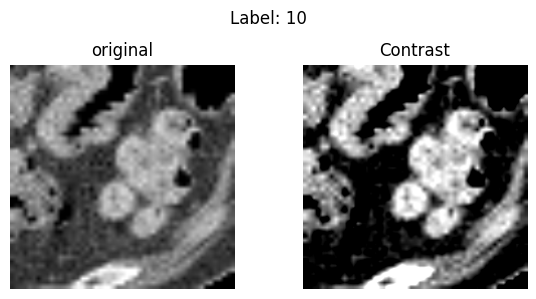

In [38]:
show_npz_image_set("/content/distorted_npz/train_subset_first_8640_contrast_images.npz", index=100)

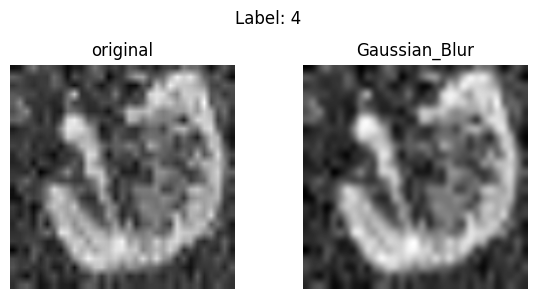

In [39]:
show_npz_image_set("/content/distorted_npz/train_subset_second_8640_gaussian_blur_images.npz", index=100)

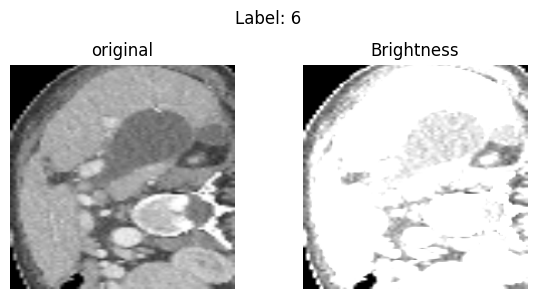

In [40]:
show_npz_image_set("/content/distorted_npz/train_subset_third_8640_brightness_images.npz", index=100)

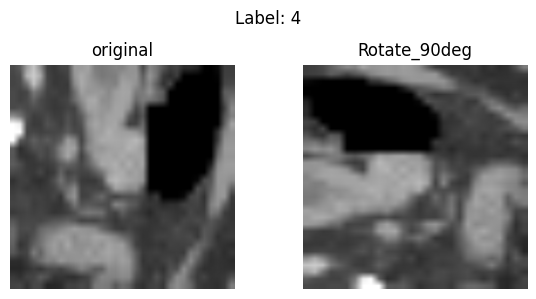

In [41]:
show_npz_image_set("/content/distorted_npz/train_subset_last_8641_rotate_90deg_images.npz", index=100)